In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer
from util import Util
from cost_data_manager import CostDataManager
from matplotlib.backends.backend_pdf import PdfPages
from keras.layers import Dense, Activation
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn import cross_validation
from sklearn import metrics as m
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from matplotlib.backends.backend_pdf import PdfPages

####
#dodano
####

from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

# configuration
############################################################
np.random.seed(1001)
report_directory = "reports" 

excel_file_video = r"video_dataset_with_costs(cost).xlsx"
excel_file_mrs = r"mrs_dataset_with_costs(cost).xlsx"

# set data mode ('mrs' or 'video')
data_mode = "mrs"

if data_mode == "mrs":
    excel_file = excel_file_mrs
elif data_mode == "video":
    excel_file = excel_file_video


cost_labels = [
                'Century Link', 
                'Google', 
                #'Azure', 
                'Amazon', 
                #'Oracle', 
                'Alibaba', 
                'DigitalOcean'
             ]
used_features = ['Users',
                 #'Avg. CPU utilization (%)',
                 'Max CPU utilization (%)',
                 'NW Egress (GB)',
                 #'Avg RAM (unused, KiB)',
                 'Avg RAM used (MB)',
                 #'Disk write bytes rate',
                 #'Disk read bytes',
                 #'Used storage(image size, GB)',
                ] 
outcome_label = 'cost'
############################################################

dataManager = CostDataManager(excel_file, outcome_label, cost_labels, used_features, data_mode=data_mode)
dataManager.load()
dataManager.exportDataset()  

def transformX(X):
    scaler = StandardScaler()

    X1 = scaler.fit_transform(X)
    X = pd.DataFrame(X1, columns=X.columns)      
    return X

def transformY(Y):
    return Y
    #data = Y.copy().values
    #data = np.sqrt(data)
    #ret = pd.Series(data)
    #return ret 
def invTrans(X):
    return X

dataManager.setXTransform(transformX)
dataManager.setYTransform(transformY)

m_all = dataManager.getMetrics()
if data_mode == 'mrs':
    m_large = dataManager.getMetricsDBLarge()
    m_xlarge = dataManager.getMetricsDBXLarge()
elif data_mode == 'video':
    m_small = dataManager.getMetricsVideoDBLarge()
    m_medium = dataManager.getMetricsVideoDBMedium()
    m_large = dataManager.getMetricsVideoDBSmall()

working_metrics = m_large
working_metrics_label = "large"
print("Total working data:", len(working_metrics))
util = Util()
util.setInvTrans(invTrans)
working_metrics.head()
X,Y = dataManager.getXY_panda(working_metrics)


Using TensorFlow backend.


0 Century Link
1 Google
2 Amazon
3 Alibaba
4 DigitalOcean
25 features removed (std +/- 3) -  all
12 features removed (std +/- 3) -  large
11 features removed (std +/- 3) -  xlarge

COST
0        477.283046
1        958.641754
2       1584.025672
3       2394.248713
4       3117.935457
5       3799.544801
6       4471.689168
7       5152.089916
8       5809.187148
9       6528.618718
10      7214.409800
11      7900.173222
12      8599.722910
13      9324.204709
14     10026.027750
15       293.058074
16       710.518988
17      1166.227835
18      1635.049669
19      2123.963076
20      2635.671259
21      3128.452819
22      3595.232119
23      4087.117767
24      5060.737383
25      6157.993331
26      6649.533711
27      7134.649605
28      7586.085524
29      8042.836403
           ...     
425      302.903589
426      407.773934
427      534.190059
428      658.503797
429     1367.678863
430     1505.688799
431     1643.333197
432     1643.333197
433     1927.301733
434     2074.0

# Neural net

In [2]:
import keras
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

#def baseline_model_1(pen=0.01):
def baseline_model_1():
    
    model = Sequential()
    model.add(Dense(32, activation = 'relu', input_dim = X.shape[1]))
    #model.add(Dense(32, activation = 'relu', kernel_initializer='normal', input_dim = X.shape[1]))
    #model.add(Dense(32, activation = 'tanh', input_dim = X.shape[1]))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 64, activation = 'relu'))
    model.add(Dense(units = 64, activation = 'relu'))
    model.add(Dense(units = 1, activation='relu'))
    
    adam = keras.optimizers.Adamax(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)    
    #model.compile(optimizer = 'rmsprop', loss = 'mse', metrics=['mse','mae'])
    model.compile(optimizer = 'rmsprop', loss = 'mse')
    return model

def baseline_model_2(pen=0.01):
    
    model = Sequential()
    #model.add(Dense(32, activation = 'relu', input_dim = X.shape[1]))
    #model.add(Dense(32, activation = 'relu', kernel_initializer='normal', input_dim = X.shape[1]))
    model.add(Dense(32, activation = 'tanh', kernel_initializer='glorot_uniform', input_dim = X.shape[1]))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 64, activation = 'relu'))
    model.add(Dense(units = 64, activation = 'relu'))
    model.add(Dense(units = 1, activation='relu'))
    
    adam = keras.optimizers.Adamax(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)    
    model.compile(optimizer = 'rmsprop', loss = 'mse', metrics=['mse','mae'])
    return model

In [3]:
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

d = dict()
for i in np.arange(0.0, 0.1, 0.02):
    # Splitting the dataset into the Training set and Test set
    X,Y = dataManager.getXY_panda(working_metrics)
    X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, test_size=0.3, random_state=0)
    
    model_1 = baseline_model_1()
    #model_2 = baseline_model_2(i)
    
    model_1.summary()

    # Fitting the ANN to the Training set
    history_1 = model_1.fit(X_train, Y_train, batch_size = 50, epochs = 500, verbose=False)
    #history_2 = model_2.fit(X_train, Y_train, batch_size = 50, epochs = 500, verbose=False)

    Y_pred_1 = model_1.predict(X_test)
    #Y_pred_2 = model_2.predict(X_test)
    
    Y_pred_1 = np.concatenate( Y_pred_1, axis=0 )
    #Y_pred_2 = np.concatenate( Y_pred_2, axis=0 )
    
    mae_1 = m.mean_absolute_error(Y_test, Y_pred_1)
    #mae_2 = m.mean_absolute_error(Y_test, Y_pred_2)
    
    print(i, mae_1)
    d[i] = mae_1
    
    
    
#Y_pred_1 = model_1.predict(X_test)
#util.regression_report(Y_test, Y_pred_1, "NN", X.shape[1])



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                288       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 7,681
Trainable params: 7,681
Non-trainable params: 0
_________________________________________________________________
0.0 133.54642868953425
_________________________________________________________________
Layer (type)                 Output Shape          

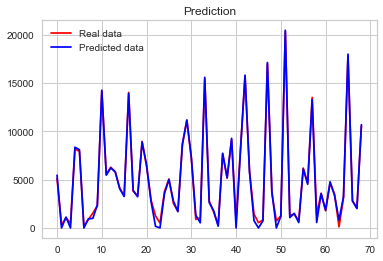

In [4]:
plt.plot(Y_test.values, color = 'red', label = 'Real data')
plt.plot(Y_pred_1, color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()



model_info = {}
model_info['model'] = model_1
model_info['X_train'] = X_train
model_info['X_test'] = X_test
model_info['Y_train'] = Y_train
model_info['Y_test'] = Y_test
model_info['predicted'] = model_1.predict(X_test)[:,0]

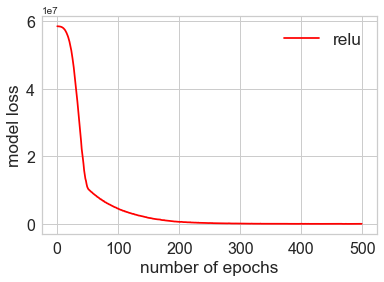

Model_1

MAE: 211.39330031077162
MSE: 95506.96472179747
MAPE: 26.775685749615093
RMSE: 309.0420112570417
EVS: 0.9962247640681208
AIC: -15.40212191486189
AICc: -13.00212191486189
BIC: 825.0927092823025
R2: 0.9959761017665713
R2(adj): 0.9954395820021141


Model_2



In [5]:
# summarize history for loss
with PdfPages(report_directory + "/cost_" + data_mode + '_graphs_NN_model_loss.pdf') as pdf:
    f, ax = plt.subplots()
    plt.plot(history_1.history['loss'], color = 'red', label = 'relu')
    #plt.plot(history_2.history['loss'], color = 'blue', label = 'tanh')
    #plt.title('model loss')
    plt.ylabel('model loss', fontsize = 'xx-large')
    plt.xlabel('number of epochs', fontsize = 'xx-large')
    plt.legend(fontsize = 'xx-large')
    plt.tick_params(axis='both', labelsize=16)
    plt.show()
    pdf.savefig(f, bbox_inches='tight')
    

print('Model_1')
print('=========')
print('')
util.regression_report(Y_test, Y_pred_1, "NN", X.shape[1])
print('')
print('')
print('Model_2')
print('=========')
print('')
#util.regression_report(Y_test, Y_pred_2, "NN", X.shape[1])

#import os
#os.environ["PATH"] += os.pathsep + 'C:/Users/SummerCamp/Anaconda3/pkgs/graphviz-2.38.0-4/Library/bin/graphviz'
#from keras.utils import plot_model
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Analysis

## Residuals 

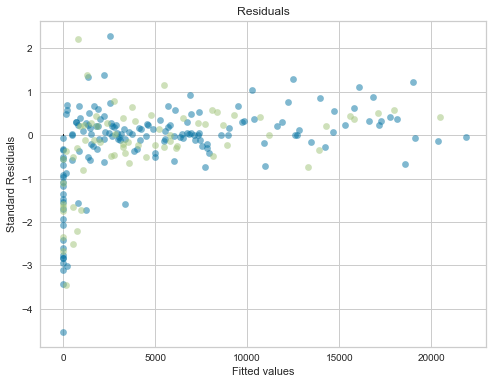

In [6]:
f, ax = plt.subplots(figsize=(8, 6))
plt.scatter(model_1.predict(X_train)[:,0], util.get_standard_residuals(model_1.predict(X_train)[:,0],Y_train), c='b', s=40, alpha=0.5)
plt.scatter(model_1.predict(X_test)[:,0], util.get_standard_residuals(model_1.predict(X_test)[:,0],Y_test), c='g', s=40, alpha=0.5)
plt.hlines(y=0, xmin=0, xmax=50)
plt.title(str(model_1))
plt.ylabel('Standard Residuals')
plt.xlabel('Fitted values')	   
plt.title("Residuals")
plt.show()

## Predicted vs Original

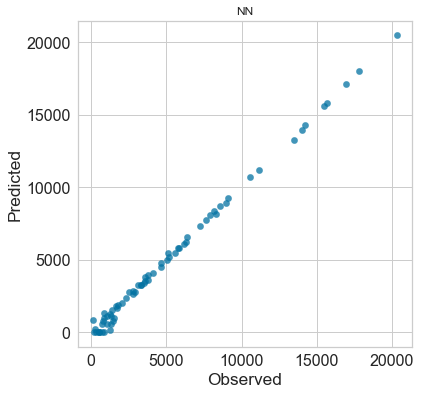

In [7]:
with PdfPages(report_directory + "/cost_" + data_mode + '_graphs_NN_predicted_vs_original.pdf') as pdf:
    f, ax = plt.subplots(figsize=(6, 6))
    util.pred_true_graph(model_info, "NN")
    #plt.legend(fontsize = 'xx-large')
    plt.show()
    pdf.savefig(f, bbox_inches='tight')
